Cite this paper if this code helps you:

F. Satter, N. Masrur and S. M. M. Ahsan, "Color Independent Word Segmentation From Transcribed Bangla Passages," 2023 6th International Conference on Electrical Information and Communication Technology (EICT), Khulna, Bangladesh, 2023, pp. 1-6, doi: 10.1109/EICT61409.2023.10427730.

Import Libraries and Mount Drive

In [2]:
from ctypes import sizeof
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import rotate
from skimage.feature import canny
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.stats import mode
import cv2
from google.colab import drive
drive.mount('/content/drive')
from google.colab.patches import cv2_imshow
global wordNo
wordNo = 0

Mounted at /content/drive


Gaussian Kernel

In [28]:
import math
def createk(kernelSize, sigma, theta):
    assert kernelSize % 2
    h = kernelSize // 2

    k = np.zeros([kernelSize, kernelSize])
    sX = sigma
    sY = sigma * theta

    for i in range(kernelSize):
        for j in range(kernelSize):
            x = i - h
            y = j - h

            eT = np.exp(-x**2 / (2 * sX) - y**2 / (2 * sY))
            xT = (x**2 - sX**2) / (2 * math.pi * sX**5 * sY)
            yT = (y**2 - sY**2) / (2 * math.pi * sY**5 * sX)

            k[i, j] = (xT + yT) * eT

    k = k / np.sum(k)
    # print(k)
    return k

Skewness Detection

In [26]:
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import rotate
from skimage.feature import canny
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.stats import mode
import cv2
def deskew(image):
    # convert to edges
    edges = canny(image)
    # Classic straight-line Hough transform between 0.1 - 180 degrees.
    tested_angles = np.deg2rad(np.arange(0.1, 180.0))
    h, theta, d = hough_line(edges, theta=tested_angles)

    # find line peaks and angles
    accum, angless, dists = hough_line_peaks(h, theta, d)

    # round the angles to 2 decimal places and find the most common angle.
    most_common_angles = mode(np.around(angless, decimals=2))[0]

    # convert the angle to degree for rotation.
    skew_angle = np.rad2deg(most_common_angles - np.pi/2)
    if skew_angle[0]>30 or skew_angle[0]<-30:
        skew_angle[0]=0
    # print(type(skew_angle))
    # print(skew_angle)
    return skew_angle

Skewness Correction

In [14]:
def deskew2(image,angle,dominant_pixel):
    #image2=rotate(image, angle, cval=1)
    h,w = image.shape
    center = (h/2,w/2)
    image2=cv2.getRotationMatrix2D(center, angle[0], scale=1)
    image2 = cv2.warpAffine(src=image, M=image2, dsize=(w,h), borderValue=int(dominant_pixel))
    fig, ax = plt.subplots(ncols=2, figsize=(20,20))
    ax[0].imshow(image, cmap="gray")
    ax[0].set_title('Input image')
    ax[1].imshow(image2, cmap="gray")
    ax[1].set_title('Skew Corrrected image')
    plt.show()
    return image2

Sorting of the segmented words according to the text

In [42]:
def sortit(allImages):
    # This portion of the code is currently under private mode as the authors are working on a new Journal.
    # Once the journal is published, this portion will be public. Thank you for understanding.


    return allImages


In [50]:
wordNo = 1

def words(img, imgno, kernelSize=1, sigma=3, theta=1, area=0,num_pixels_below_threshold = 0,backgroundColor = 255):

    # setting up different kernel size based on area
    res = []
    it=0
    color = (0,255,0)
    th = 2
    isThereNoise = 0
    noiseCount = 0
    kernelSize=21
    sigma=21
    theta=7
    krnl = createk(kernelSize, sigma, theta)
    iF = cv2.filter2D(img, -1, krnl, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
    # cv2_imshow (iF)
    # iF = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
    blockSizeForThreshold = int(area / 20)
    if (blockSizeForThreshold % 2 == 0):
      blockSizeForThreshold +=1

    iT = cv2.adaptiveThreshold(iF,255,cv2.ADAPTIVE_THRESH_MEAN_C ,cv2.THRESH_BINARY,21,2)
    # (_, iT) = cv2.threshold(iF, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # print ("ORERERERE")
    # cv2_imshow(iT)

    dominant_pixel = np.argmax(np.bincount(iT.flatten())).astype(np.uint8)
    # print ("dominant pixel = ",  dominant_pixel)

    # angle = deskew(iT)
    # iT = deskew2(iT,angle,dominant_pixel)
    # cv2_imshow(iT)

    if (dominant_pixel == 255 ):
      iT = 255 - iT
    # cv2_imshow(iT)


    if cv2.__version__.startswith('3.'):
        (_, cS, _) = cv2.findContours(iT, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else:
        (cS, _) = cv2.findContours(iT, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    avgContourSize = 0

    counter = 0
    for c in cS:
        if cv2.contourArea(c) < 50:
          noiseCount += 1
          continue

        avgContourSize += cv2.contourArea(c)
        counter = counter +1
    # print ("avgContourSize = ",avgContourSize/counter)

    if (noiseCount >2000):
      isThereNoise = 1
      # print ("Noise ache. Number of Noise = ",noiseCount)


    avgContourSize = avgContourSize/counter
    # setting up different kernel size based on avgContourSize
    if (avgContourSize < 100):
        kernelSize=3
        sigma=3
        theta=7
    else :
      diffFromStandard = 1000 - avgContourSize
      if (diffFromStandard == 0):
        kernelSize=21
        sigma=21
        theta=7
      elif (diffFromStandard > 0 ):
        div = diffFromStandard / 50
        kernelSize=int (21 - div )
        sigma=int (21 - div )
        theta=7
      elif (diffFromStandard < 0 ):
        div = diffFromStandard / 100
        kernelSize= int(21 - div )
        sigma=int(21 - div )
        theta=7
    print (kernelSize, sigma, theta)
    if (kernelSize %2 == 0):
      kernelSize -= 1
      sigma -= 1
    if (backgroundColor <= 100):
      kernelSizeForSmoothing = kernelSize + 4
      sigmaForSmoothing = sigma + 4
      kernelSizeForThreshold = kernelSize + 4
    elif (backgroundColor <= 180):
      kernelSizeForSmoothing = kernelSize + 2
      sigmaForSmoothing = sigma + 2
      kernelSizeForThreshold = kernelSize + 2

    else :
      kernelSizeForSmoothing = kernelSize
      sigmaForSmoothing = sigma
      kernelSizeForThreshold = kernelSize
    krnl = createk(kernelSizeForSmoothing, sigmaForSmoothing, theta)
    iF = cv2.filter2D(img, -1, krnl, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
    # print ("Final Smoothing , In Sha Allah")
    # cv2_imshow (iF)


    # iT = cv2.adaptiveThreshold(iF,255,cv2.ADAPTIVE_THRESH_MEAN_C ,cv2.THRESH_BINARY,kernelSizeForThreshold,2)
    # cv2_imshow(iT)
    # Shadow Detection by Otsu
    (_, otsuDetection) = cv2.threshold(iF, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # print ("Shadow Checking Otsu")
    # cv2_imshow (otsuDetection)
    dominant_pixelOtsuShadow = np.argmax(np.bincount(otsuDetection.flatten())).astype(np.uint8)
    if (dominant_pixelOtsuShadow == 255 ):
      otsuDetection = 255 - otsuDetection
    if cv2.__version__.startswith('3.'):
      (_, otsucS, _) = cv2.findContours(otsuDetection, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else:
      (otsucS, _) = cv2.findContours(otsuDetection, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    countourAreaList = []
    maxContourAreaOtsu = -1
    isThereShadow = 0
    imgcpForShadowChecking = img.copy()
    for c in otsucS:
        countourAreaList.append(cv2.contourArea(c))
        # print("countour area",cv2.contourArea(c))
        if (cv2.contourArea(c) > maxContourAreaOtsu):
          maxContourAreaOtsu = cv2.contourArea(c)
    #       cB = cv2.boundingRect(c)
    #       (x, y, w, h) = cB
    #       currImg = img[y:y+h, x:x+w]
    #       cv2.rectangle(imgcpForShadowChecking, (x,y), (x+w,y+h), color,th)
    # fig, ax = plt.subplots(ncols=2, figsize=(20,20))
    # ax[0].imshow(img, cmap="gray")
    # ax[0].set_title('input image')
    # ax[1].imshow(imgcpForShadowChecking, cmap="gray")
    # ax[1].set_title('Boxed image')
    # plt.show()
    # print ("maxContourAreaOtsu = ",maxContourAreaOtsu)
    # cv2_imshow (otsuDetection)
    standardDeviationOfContourOtsu = np.std(countourAreaList)
    # print ("standardDeviationOfContourOtsu =",standardDeviationOfContourOtsu)
    # print ("Shadow ache , shadow ",(maxContourAreaOtsu/avgContourSize),"%")
    if ((maxContourAreaOtsu/avgContourSize) > 100):
      # print ("Shadow ache , shadow ",(maxContourAreaOtsu/avgContourSize),"%")
      isThereShadow = 1

    adaptiveThresholdFlag = 0
    if (backgroundColor >=180 and isThereShadow == 0):
      (_, iT) = cv2.threshold(iF, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
      # print ("OTSU KORSI ")
    else :
      iT = cv2.adaptiveThreshold(iF,255,cv2.ADAPTIVE_THRESH_MEAN_C ,cv2.THRESH_BINARY,kernelSizeForThreshold,2)
      adaptiveThresholdFlag = 1
      # print ("Adaptive KORSI ")
    # angle = deskew(iT)
    # iT = deskew2(iT,angle,dominant_pixel)
    # print ("EI JE SKEW")
    # cv2_imshow(iT)
    # img = deskew2(img,angle,dominant_pixel)

    if (dominant_pixel == 255 ):
      iT = 255 - iT


    if cv2.__version__.startswith('3.'):
        (_, cS, _) = cv2.findContours(iT, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else:
        (cS, _) = cv2.findContours(iT, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    avgContourSize = 0

    counter = 0
    for c in cS:
        if cv2.contourArea(c) < 50:
          continue
        avgContourSize += cv2.contourArea(c)
        counter = counter +1
    avgContourSize = avgContourSize/counter
    # print ("NEW AVERAGE CONTOUR SIZE = ",avgContourSize)



    # print ("after Thresholding")
    # cv2_imshow(iT)

    # kernelForClosing = cv2.getStructuringElement(cv2.MORPH_RECT, (kernelSize, kernelSize))

    # # Perform opening operation
    # iT = cv2.morphologyEx(iT, cv2.MORPH_OPEN, kernelForClosing)
    # print ("Result after opening")
    # cv2_imshow(iT)

    # if cv2.__version__.startswith('3.'):
    #     (_, cS, _) = cv2.findContours(iT, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # else:
    #     (cS, _) = cv2.findContours(iT, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # minArea = 0
    # counter = 0
    # for c in cS:
    #     minArea += cv2.contourArea(c)
    #     counter = counter +1
    # print ("minArea = ",minArea/counter)


    # dilation_kernel_size = kernelSize
    # dilation_kernel = np.ones((dilation_kernel_size,dilation_kernel_size), np.uint8)
    # iT= cv2.dilate(iT, dilation_kernel, iterations = 3)
    # print ("After Dilation")
    # cv2_imshow(iT)
    if (adaptiveThresholdFlag == 1):
      writingDensity = area / avgContourSize
      # print ("writingDensity = ",writingDensity)
      if (writingDensity < 1500):
        minArea = avgContourSize - avgContourSize/4
      elif (writingDensity < 2500):
        minArea = avgContourSize * 2 - avgContourSize/3
      elif (writingDensity < 4000):
        minArea = avgContourSize * 3 - avgContourSize/3
      elif (writingDensity < 6000):
        minArea = avgContourSize * 4 - avgContourSize/4
      elif (writingDensity < 8000):
        minArea = avgContourSize * 4
      elif (writingDensity < 10000):
        minArea = avgContourSize * 5 - avgContourSize/2
      else :
        minArea = avgContourSize * 6

      if (avgContourSize > 1100 and writingDensity>7000):
        minArea += avgContourSize
      elif (avgContourSize > 1500 and writingDensity >7000):
        minArea += avgContourSize*1.5
      elif (avgContourSize <700 and writingDensity <2000):
        minArea = minArea - avgContourSize/8
      # minArea = (area/ avgContourSize - avgContourSize)/2
    else:
      # / 1.25
      avgContourSize = avgContourSize / 1.25
      minArea = avgContourSize
    # print ("minArea = ",minArea)

    iteration = 1
    previousCounter = 0
    previousIT = iT.copy()
    output_for_word = img.copy()
    if (avgContourSize < 100):
      dilation_kernel_size = 1
    elif (avgContourSize < 1000):
      dilation_kernel_size = 3
    elif (avgContourSize < 1300):
      dilation_kernel_size = 5
    elif (avgContourSize <1500 ):
      dilation_kernel_size = 7
    elif (avgContourSize <1800 ):
      dilation_kernel_size = 9
    else :
      temp =  avgContourSize - 2000
      temp = int(temp /200)

      dilation_kernel_size = 11 + temp

    if (dilation_kernel_size >= 10 and adaptiveThresholdFlag == 0 and avgContourSize > 2000):
      dilation_kernel_size -= 2


    # print ("Starting Dilation kernel size = ",dilation_kernel_size ," * ", dilation_kernel_size )

    # dilation_kernel_size = 3
    bestCounter = -1
    previousCounter = -1
    bestIteration = -1
    bestDilationKernelSize = -1
    while (1):
        counter = 0
        dilation_kernel = np.ones((dilation_kernel_size,dilation_kernel_size), np.uint8)
        # iT = cv2.morphologyEx(iT, cv2.MORPH_CLOSE, dilation_kernel, iterations=iteration)
        # print(dilation_kernel)
        # tempIT = iT
        # print(kernelSize)
        iT = cv2.dilate(iT, dilation_kernel, iterations = iteration)
        # print ( "dilation Kernel size = ", dilation_kernel_size)
        # print("iteration = ", iteration)
        # cv2_imshow(iT)
        if cv2.__version__.startswith('3.'):
            (_, cS, _) = cv2.findContours(iT, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        else:
            (cS, _) = cv2.findContours(iT, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


        res = []
        it=0
        color = (0,255,0)
        th = 2
        imgcp=img.copy()

        for c in cS:
            # print("countour area",cv2.contourArea(c))

            if cv2.contourArea(c) < minArea:
                continue
            counter = counter +1
            it=it+1


        individualWordCount = 0
        # print("previous Counter", previousCounter)
        # print("Current Counter",counter)
        iT = previousIT.copy()
        if (counter > bestCounter):
          bestCounter = counter
          bestCS = cS
          bestIteration = iteration
          bestDilationKernelSize = dilation_kernel_size
        elif (counter == bestCounter):
          if (iteration > bestIteration):
            bestCounter = counter
            bestCS = cS
            bestIteration = iteration
            bestDilationKernelSize = dilation_kernel_size
        if (iteration < 15 and previousCounter <= counter):
          iteration += 1
          previousCounter = counter
        else:

          iteration = 1
          dilation_kernel_size += 1
          previousCounter = -1
        if (dilation_kernel_size == 21 or dilation_kernel_size >21):
          break

    dilation_kernel = np.ones((bestDilationKernelSize,bestDilationKernelSize), np.uint8)
    iTForOTSUDisplay = cv2.dilate(previousIT, dilation_kernel, iterations = bestIteration)
    # print ("bestOtsuCounter = " , bestCounter)
    # print ("bestOtsuIteration = ",bestIteration)
    # print ("bestOtsuilationKernelSize = ",bestDilationKernelSize )
    # cv2_imshow(iTForOTSUDisplay)
    counter = bestCounter
    CS = bestCS
    img = img.copy()
    imgcp = imgcp.copy()


    # sorted_contours = sorted(CS, key=cv2.contourArea)


    # # Calculate the area of the minimum contour
    # for i in range (0,len(sorted_contours)):
    #   if cv2.contourArea(sorted_contours[i]) < minArea :
    #     continue
    #   else :
    #     min_contour_area_index = i
    #     break

    # min_contour = sorted_contours[min_contour_area_index]
    # min_contour_area = cv2.contourArea(min_contour)

    # # Print the area of the minimum contour
    # print("Minimum Contour Area:", min_contour_area)
    # image_with_contour = img.copy()
    # cv2.drawContours(image_with_contour, [min_contour], -1, (0, 255, 0), 2)
    # x, y, w, h = cv2.boundingRect(min_contour)

    # # Draw the bounding box
    # cv2.rectangle(image_with_contour, (x, y), (x+w, y+h), (0, 0, 255), 2)

    # # Display the original image and the image with the minimum contour

    # cv2_imshow( image_with_contour)

    for c in CS:

      # wordStoreList
      if cv2.contourArea(c) < minArea:
          continue
      cB = cv2.boundingRect(c)
      (x, y, w, h) = cB
      currImg = img[y:y+h, x:x+w]
      global wordNo
      res.append((cB, currImg))

      # print(res.shape)
      cv2.rectangle(imgcp, (x,y), (x+w,y+h), color,th)
      it=it+1

      # cv2_imshow(currImg)

    temp = sortit(res)



    for i in range (len(temp)):
      # print("img co: ", temp[i][0])
      # cv2_imshow(temp[i][1])
      output_for_words = temp[i][1]
      # (_, output_for_words) = cv2.threshold(output_for_words, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
      # cv2_imshow(output_for_words)
      # WordTrainSetDirectoryName = "/content/drive/MyDrive/bbbbb/N"+f'{wordNo}'+".bmp"
      # cv2.imwrite(WordTrainSetDirectoryName, output_for_words)
      wordNo +=1
    fig, ax = plt.subplots(ncols=2, figsize=(20,20))
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title('input image')
    ax[1].imshow(imgcp, cmap="gray")
    plt.imsave('word'+str(imgno)+'.jpg',imgcp,cmap="gray")
    ax[1].set_title('Boxed image')
    plt.show()

    WordTrainSetDirectoryName = "/content/drive/MyDrive/Thesis-OCR/Word Outputs/"+f'{imgno}'+".jpg"
    cv2.imwrite(WordTrainSetDirectoryName, imgcp)
    cv2.imwrite('Tensorflow/r %d.jpg' % (imgno),imgcp)
    return counter


/content/drive/MyDrive/Thesis-OCR/PromitoLipi1.1/Paragraph Images(bmp)/B022.bmp
23 23 7


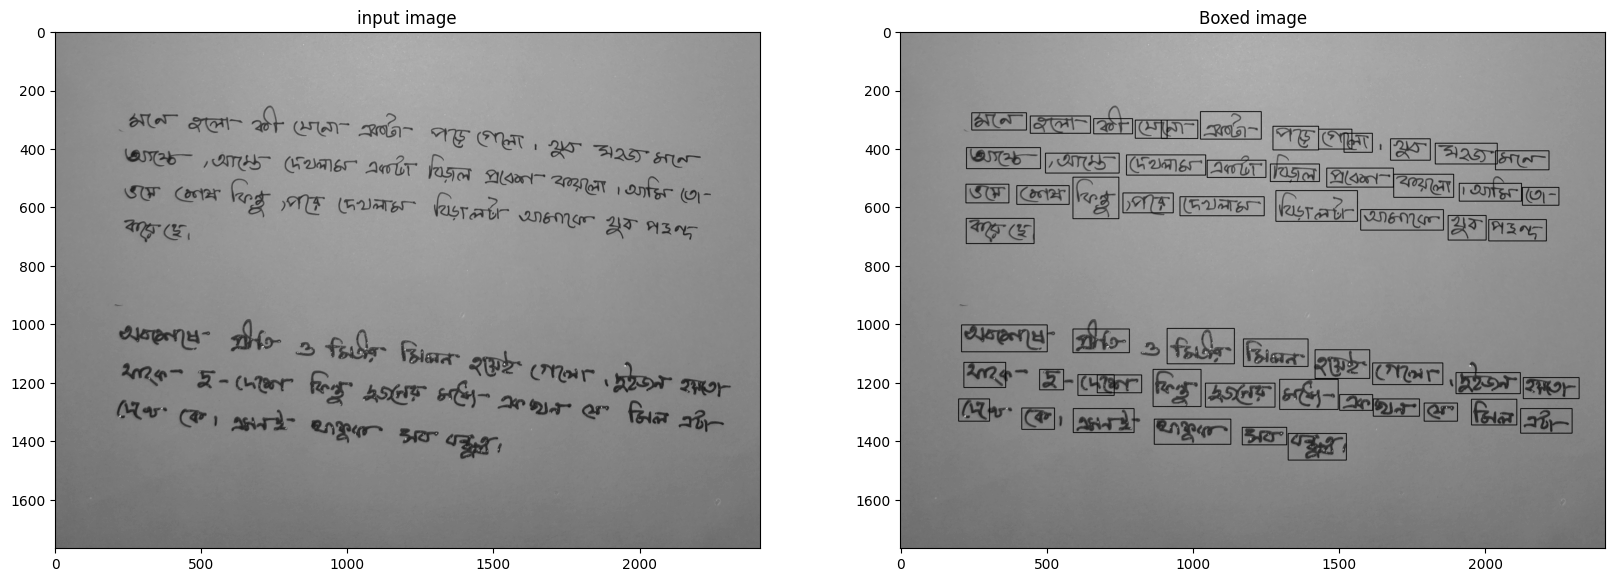

57
number of image =
22
/content/drive/MyDrive/Thesis-OCR/PromitoLipi1.1/Paragraph Images(bmp)/B023.bmp
16 16 7


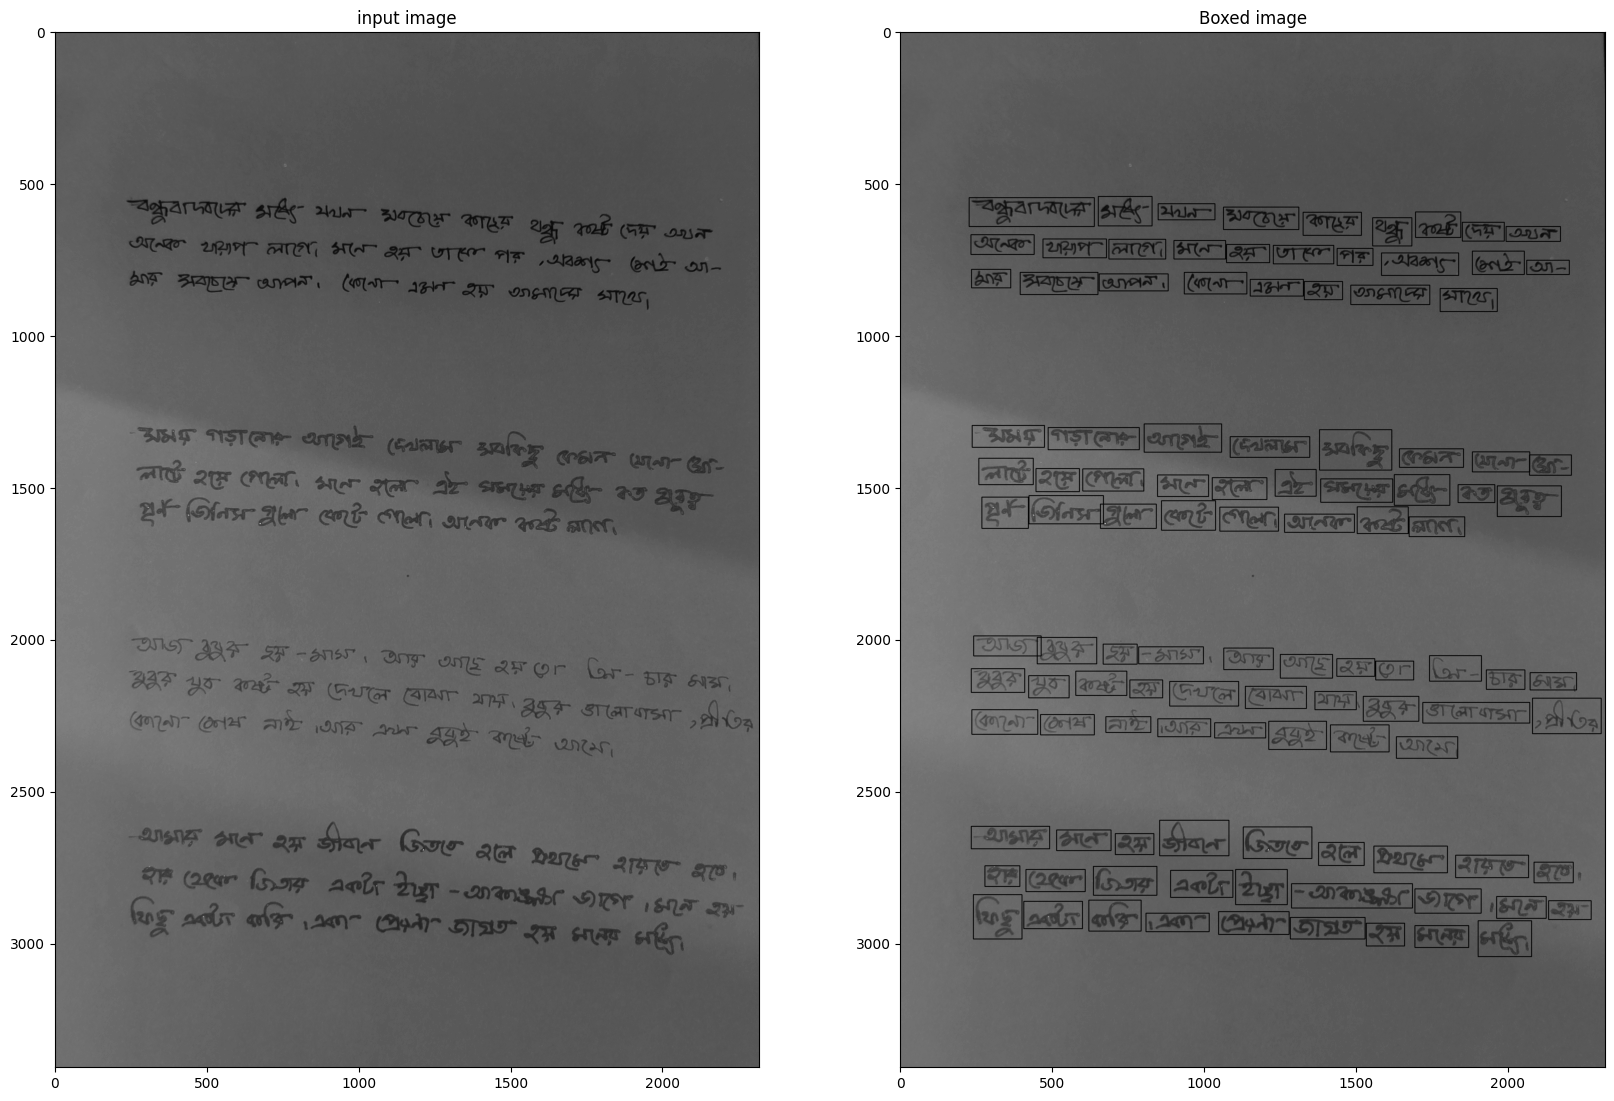

109
number of image =
23


In [53]:


paragraphTrainSetSize = 100
# /content/drive/MyDrive/Drive

for i in range(22,24) :  #CHANGE HERE AFTER DOWNLOADING THE WHOLE DATASET. IT WILL BE for i in range(1,81)
  paragraphTrainSetDirectoryName = "/content/drive/MyDrive/Thesis-OCR/PromitoLipi1.1/Paragraph Images(bmp)/B"+f'{i:03d}'+".bmp" #f'{i:03d}
  paragraphTrainSetPath = paragraphTrainSetDirectoryName
  print(paragraphTrainSetPath)
  img=cv2.imread(paragraphTrainSetPath,cv2.IMREAD_GRAYSCALE)
  # if img != True:
  #   break
  # cv2_imshow(img)
  totalNumberOfWords = 0
  ho,wo=img.shape
  imgno=i
  # area/2000
  area=ho*wo
  threshold = 200
  num_pixels_above_threshold = np.sum(img > threshold)
  num_pixels_above_threshold = num_pixels_above_threshold /area
  # print ("num_pixels_above_threshold = ",num_pixels_above_threshold)
  # a4Size = 4000 * 3000
  # ratio = area / a4Size
  # print ("ratio = ",ratio)
  # print ("ho,wo,area = ",ho,wo,area)
  # print ("(area/2000)*ratio = ",((area/2000)*ratio))
  # dominant_pixel = np.argmax(np.bincount(img.flatten())).astype(np.uint8)
  # resized_image = img.copy()
  # if (area < (4000*3000)):
  #   if (wo < 3000):
  #     desired_width = 3000
  #     current_width = wo
  #     padding_width = (desired_width - current_width) // 2
  #     resized_image = cv2.copyMakeBorder(resized_image, top=0, bottom=0, left=padding_width, right=padding_width, borderType=cv2.BORDER_CONSTANT, value=int(dominant_pixel))
  #   if (ho <4000):
  #     desired_height = 4000
  #     current_height = ho
  #     padding_height = (desired_height - current_height) // 2
  #     resized_image = cv2.copyMakeBorder(resized_image, top=padding_height, bottom=padding_height, left=0, right=0, borderType=cv2.BORDER_CONSTANT, value=int(dominant_pixel))

  # cv2_imshow(resized_image)
  # ho,wo=resized_image.shape
  # area=ho*wo
  backgroundColor = np.argmax(np.bincount(img.flatten())).astype(np.uint8)
  # print ("backgroundColor = ",  backgroundColor)
  ara=words(img,imgno,25,11,7,area,num_pixels_above_threshold,backgroundColor)
  # 2480 x 3508 / 2000 = 4350

  totalNumberOfWords= totalNumberOfWords+ara
  # print(ara)
  print(totalNumberOfWords)

  print('number of image =')
  print(imgno)

Special Thank you to :
M. S. Hasan and A. Pal, “Optical character recognition for handwritten bangla documents,” 2021, unpublished undergraduate thesis.

In case of need, many code snippets were collected from Hasan et al's work and then upgraded. Authors will be forever grateful to them.